# Modeling

### 1. Importação de Bibliotecas

In [1]:
import pandas as pd 
import numpy as np 
import shutil
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pyspark.sql import functions as F
from src.utils.spark_utils import create_spark_session, get_parquet_path,load_parquet_to_df
from pyspark.sql import SparkSession

### 2. Inicialização da SparkSession e Carregamento dos Dados

In [2]:
# Inicializar a SparkSession
spark = create_spark_session()

input_path = get_parquet_path()

df_model = load_parquet_to_df(spark, input_path)

df_model.printSchema()
df_model.show(5, truncate=False)
# df_model.cache()
df_model.unpersist()  

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/29 19:53:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- Recency: integer (nullable = true)
 |-- Frequency: long (nullable = true)
 |-- Monetary: double (nullable = true)
 |-- Recency_scaled: double (nullable = true)
 |-- Frequency_scaled: double (nullable = true)
 |-- Monetary_scaled: double (nullable = true)
 |-- Recency_score: integer (nullable = true)
 |-- Frequency_score: integer (nullable = true)
 |-- Monetary_score: integer (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- maxAbsFeatures: vector (nullable = true)
 |-- features_vector: vector (nullable = true)
 |-- RFM: integer (nullable = true)
 |-- features_pca: vector (nullable = true)
 |-- z_Recency_scaled: double (nullable = true)
 |-- z_Frequency_scaled: double (nullable = true)
 |-- z_Monetary_scaled: double (nullable = true)

+-------+---------+------------------+--------------------+-------------------+--------------------+-------------+---------------+--------------+----------+---------------------------------------------------------------+----------

DataFrame[Recency: int, Frequency: bigint, Monetary: double, Recency_scaled: double, Frequency_scaled: double, Monetary_scaled: double, Recency_score: int, Frequency_score: int, Monetary_score: int, CustomerID: int, maxAbsFeatures: vector, features_vector: vector, RFM: int, features_pca: vector, z_Recency_scaled: double, z_Frequency_scaled: double, z_Monetary_scaled: double]

### 3. Validação da Distribuição das Variáveis RFM Antes da Modelagem

Este gráfico verifica se a normalização aplicada garantiu uma distribuição adequada das variáveis RFM (Recency, Frequency e Monetary). A intenção é validar a escala e a forma dos dados antes da modelagem, assegurando que a padronização esteja correta e evitando viés nos clusters.

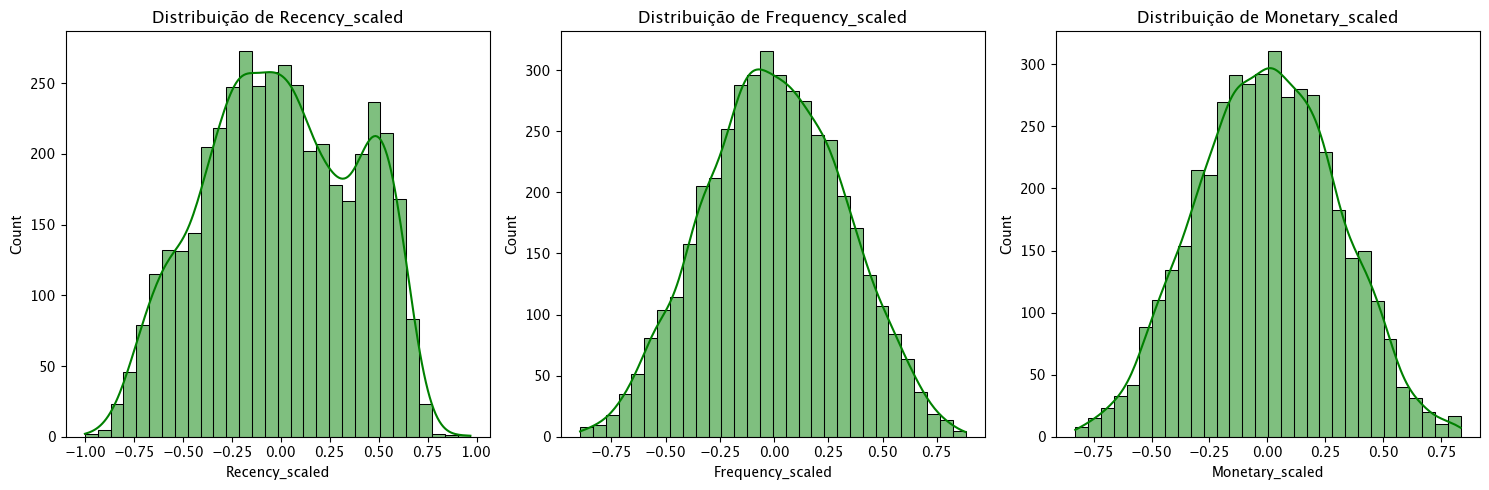

In [3]:

df_pandas = df_model.select("Recency_scaled", "Frequency_scaled", "Monetary_scaled").toPandas()


plt.figure(figsize=(15, 5))
for i, column in enumerate(["Recency_scaled", "Frequency_scaled", "Monetary_scaled"]):
    plt.subplot(1, 3, i + 1)
    sns.histplot(df_pandas[column], kde=True, bins=30, color="green")
    plt.title(f"Distribuição de {column}")
plt.tight_layout()
plt.show()

### 4. Modelagem - Fuzzy C-Means (FCM)

 #### Modelagem Matemática do Fuzzy C-Means (FCM) e sua Aplicação no Negócio

 **Definição do Fuzzy C-Means**

O **Fuzzy C-Means (FCM)** é um algoritmo de **clusterização não supervisionada** que permite que um ponto de dados pertença a múltiplos clusters com diferentes graus de associação, ao invés de uma atribuição rígida como no K-Means.

O FCM busca minimizar a seguinte **função de custo**:

$
J_m = \sum_{i=1}^{N} \sum_{j=1}^{C} u_{ij}^m \cdot d_{ij}^2
$

**Onde:**
- $N$ é o número total de pontos de dados.
- $C$ é o número de clusters.
- $u_{ij}$ representa o grau de associação do ponto $i$ ao cluster $j$ (**matriz de pertinência**).
- $m$ é o **grau de fuzzificação**, um parâmetro que controla a difusão dos clusters ($m > 1$).
- $d_{ij}$ é a **distância euclidiana** entre o ponto $x_i$ e o centróide $c_j$:

$
d_{ij} = \| x_i - c_j \|
$

Os centróides dos clusters são atualizados iterativamente com:

$
c_j = \frac{\sum_{i=1}^{N} u_{ij}^m \cdot x_i}{\sum_{i=1}^{N} u_{ij}^m}
$

E os coeficientes de pertinência são recalculados como:

$
u_{ij} = \frac{1}{\sum_{k=1}^{C} \left(\frac{d_{ij}}{d_{ik}}\right)^{\frac{2}{m-1}}}
$

O processo continua até que a mudança na função objetivo seja menor que um critério de convergência $( \epsilon )$.

---

#### **Por que utilizar Fuzzy C-Means para Segmentação de Clientes (RFM)?**

1. **Pertinência Suave**  
   Clientes podem apresentar **características intermediárias** entre múltiplos clusters, tornando inadequado o uso de métodos que impõem separações rígidas.

2. **Maior Robustez a Outliers**  
   Diferente do K-Means, que força cada ponto a um cluster específico, o FCM distribui o impacto de valores extremos entre diversos clusters, reduzindo distorções.

3. **Representação mais Realista do Comportamento do Cliente**  
   No contexto de **RFM (Recência, Frequência, Monetário)**, um cliente pode ser **tanto recorrente quanto de alto valor**, e a modelagem fuzzy permite essa dualidade ao invés de forçar uma única categorização.

4. **Matriz de Probabilidades**  
   Com o FCM, podemos gerar insights sobre **o grau de pertencimento** de cada cliente a um cluster, permitindo **estratégias personalizadas de retenção e engajamento**.

---

#### **Observação**
O **Fuzzy C-Means** foi escolhido pois a segmentação de clientes não é estritamente separável. O **grau de fuzzificação \( m = 1.5 \)** foi definido para evitar tanto a excessiva sobreposição dos clusters quanto uma separação muito rígida.  

Esse modelo melhora a capacidade de personalização de **campanhas de marketing, retenção de clientes e análise de churn**, permitindo uma abordagem granular baseada na **probabilidade de pertencimento** a cada cluster.

In [4]:

fuzzy_data = df_model.select("Recency_scaled", "Frequency_scaled", "Monetary_scaled",).toPandas()
data_matrix_fuzzy = fuzzy_data[["Recency_scaled", "Frequency_scaled", "Monetary_scaled"]].to_numpy().T  # Transpor para colunas


# Inicializa o modelo Fuzzy C-Means
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data_matrix_fuzzy,  
    c=5,              
    m=1.5,             # Grau de fuzzificação 
    error=0.00005,      # Critério de erro
    maxiter=500,      
    init=None         
)

# Determinar os clusters mais prováveis
labels_fuzzy = np.argmax(u, axis=0)  # Determina os clusters mais prováveis
probas_fuzzy = u  # Matriz de probabilidade de associação

# Criar DataFrame
fuzzy_data["Cluster"] = labels_fuzzy
fuzzy_data["Probability"] = probas_fuzzy.max(axis=0)  # Probabilidade máxima para o cluster mais provável


df_fuzzy_clusters = spark.createDataFrame(fuzzy_data)  
# df_fuzzy_clusters = df_fuzzy_clusters.cache()  
df_fuzzy_clusters = df_fuzzy_clusters.unpersist()  

df_fuzzy_clusters.show()
df_fuzzy_clusters = df_fuzzy_clusters.withColumn("Probability", F.round(F.col("Probability"), 5)) 
df_fuzzy_clusters.write.mode("overwrite").parquet("path_to_save/fuzzy_clusters.parquet")  

+--------------------+--------------------+--------------------+-------+-------------------+
|      Recency_scaled|    Frequency_scaled|     Monetary_scaled|Cluster|        Probability|
+--------------------+--------------------+--------------------+-------+-------------------+
|-0.27917869859051464| -0.1955818095754434|-0.16650806267218982|      0| 0.9982814742952517|
| -0.7361468599430526|  0.5104348572770504|  0.4624345299144035|      1| 0.9780681814951909|
| -0.5815424918197976|  0.6067787437008338|  0.5174060399585269|      1| 0.9785183363831984|
|-0.23294771878344422| 0.09362215370233165| 0.06023012096563433|      3|  0.916682202496335|
| -0.5815424918197976| 0.00819315338868849|  0.6911439322144552|      1| 0.7166250383007312|
|  -0.218863823819583| 0.07671268469797171|  0.4788567381059637|      3| 0.6949762094110354|
| -0.2961382812339113|  0.3172597468674926| 0.22233948962314326|      3| 0.6888383793411547|
|-0.33290020138454696|  0.5530621900546807|  0.3057766046349175|      

In [5]:
# Determinar os clusters mais prováveis
labels_fuzzy = np.argmax(u, axis=0)  # Determina os clusters mais prováveis
probas_fuzzy = u                     # Matriz de probabilidades de associação

print(f"Clusters formados: {set(labels_fuzzy)}")
print(f"Grau de associação médio (FPC): {fpc:.4f}")
print(probas_fuzzy[:, :5])  # Mostra as primeiras probabilidades

Clusters formados: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)}
Grau de associação médio (FPC): 0.7147
[[9.98281474e-01 3.41032553e-03 2.48561627e-03 5.51527506e-02
  5.41133418e-02]
 [1.58157205e-04 9.78068181e-01 9.78518336e-01 1.66286630e-02
  7.16625038e-01]
 [2.24634360e-04 6.27387274e-04 5.39794984e-04 1.66282880e-03
  9.72512787e-03]
 [9.12787690e-04 1.60937649e-02 1.67015013e-02 9.16682202e-01
  1.91603029e-01]
 [4.22946449e-04 1.80034076e-03 1.75475107e-03 9.87355510e-03
  2.79334633e-02]]


In [6]:
# Converter PySpark DataFrame para Pandas apenas com a coluna CustomerID
customer_ids = df_model.select("CustomerID").toPandas()["CustomerID"]

# Criar DataFrame Pandas com os dados fuzzy
pandas_df_fuzzy = pd.DataFrame(data_matrix_fuzzy.T, columns=["Recency_scaled", "Frequency_scaled", "Monetary_scaled"])

# Adicionar os CustomerID ao DataFrame fuzzy
pandas_df_fuzzy["CustomerID"] = customer_ids.values

# Adicionar os rótulos de cluster (predictions)
pandas_df_fuzzy["prediction"] = labels_fuzzy
pandas_df_fuzzy["Cluster"] = np.argmax(probas_fuzzy, axis=0)

# # Exibir as primeiras linhas para conferência
# print(pandas_df_fuzzy.head())

### 5. Salvando os Dados para Evaluation

In [7]:
# Obter o caminho absoluto do diretório do projeto
project_path = os.path.abspath(os.path.join(os.path.dirname("__file__"), '..'))

# Definir o diretório onde os dados serão salvos
output_model_path = os.path.join(project_path, 'RID184082_Desafio07/project/src/data/processed_data')

# Criar o diretório caso não exista
os.makedirs(output_model_path, exist_ok=True)

# Caminhos para salvar os arquivos
df_clustered_parquet_path = os.path.join(output_model_path, 'df_clustered.parquet')
fuzzy_parquet_path = os.path.join(output_model_path, 'df_fuzzy.parquet')
matrix_fuzzy_npy_path = os.path.join(output_model_path, 'data_matrix_fuzzy.npy')
labels_fuzzy_npy_path = os.path.join(output_model_path, 'labels_fuzzy.npy')
probas_fuzzy_npy_path = os.path.join(output_model_path, 'probas_fuzzy.npy')
fpc_npy_path = os.path.join(output_model_path, 'fpc.npy')
u_npy_path = os.path.join(output_model_path, 'u.npy')



# Salvar DataFrame de clusterização fuzzy (Pandas -> Parquet)
pandas_df_fuzzy.to_parquet(fuzzy_parquet_path, index=False)



# Salvar matrizes NumPy para uso posterior
np.save(matrix_fuzzy_npy_path, data_matrix_fuzzy)
np.save(labels_fuzzy_npy_path, labels_fuzzy)
np.save(probas_fuzzy_npy_path, probas_fuzzy)
np.save(fpc_npy_path, fpc)
np.save(u_npy_path, u)


spark.stop()
# Exibir os caminhos salvos
print(f"""
Arquivos salvos com sucesso:
 - DataFrame de clusters (PySpark): {df_clustered_parquet_path}
 - DataFrame de clusterização fuzzy (Pandas): {fuzzy_parquet_path}
 - Matriz de dados fuzzy (NumPy): {matrix_fuzzy_npy_path}
 - Rótulos fuzzy (NumPy): {labels_fuzzy_npy_path}
 - Probabilidades de associação fuzzy (NumPy): {probas_fuzzy_npy_path}
 - Grau de associação médio (FPC) (NumPy): {fpc_npy_path}

""")


Arquivos salvos com sucesso:
 - DataFrame de clusters (PySpark): /Users/rodrigocampos/Documents/RID184082_Desafio07/project/src/data/processed_data/df_clustered.parquet
 - DataFrame de clusterização fuzzy (Pandas): /Users/rodrigocampos/Documents/RID184082_Desafio07/project/src/data/processed_data/df_fuzzy.parquet
 - Matriz de dados fuzzy (NumPy): /Users/rodrigocampos/Documents/RID184082_Desafio07/project/src/data/processed_data/data_matrix_fuzzy.npy
 - Rótulos fuzzy (NumPy): /Users/rodrigocampos/Documents/RID184082_Desafio07/project/src/data/processed_data/labels_fuzzy.npy
 - Probabilidades de associação fuzzy (NumPy): /Users/rodrigocampos/Documents/RID184082_Desafio07/project/src/data/processed_data/probas_fuzzy.npy
 - Grau de associação médio (FPC) (NumPy): /Users/rodrigocampos/Documents/RID184082_Desafio07/project/src/data/processed_data/fpc.npy


